In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from modules.StochasticProcess import StochasticProcess
from modules.ECGcleaner import ECGcleaner
from modules.QRSdetector import QRSdetector
from modules.ECGestimator import ECGestimator
from modules.Evaluator import Evaluator

In [5]:
sp = "a01"
data_extension = ".csv"
gt_extension = ".fqrs.txt"
data_path = "../data/set-a-text"
results_path = "../results"

sp_path = os.path.join(data_path, sp+data_extension)
gt_path = os.path.join(data_path, sp+gt_extension)

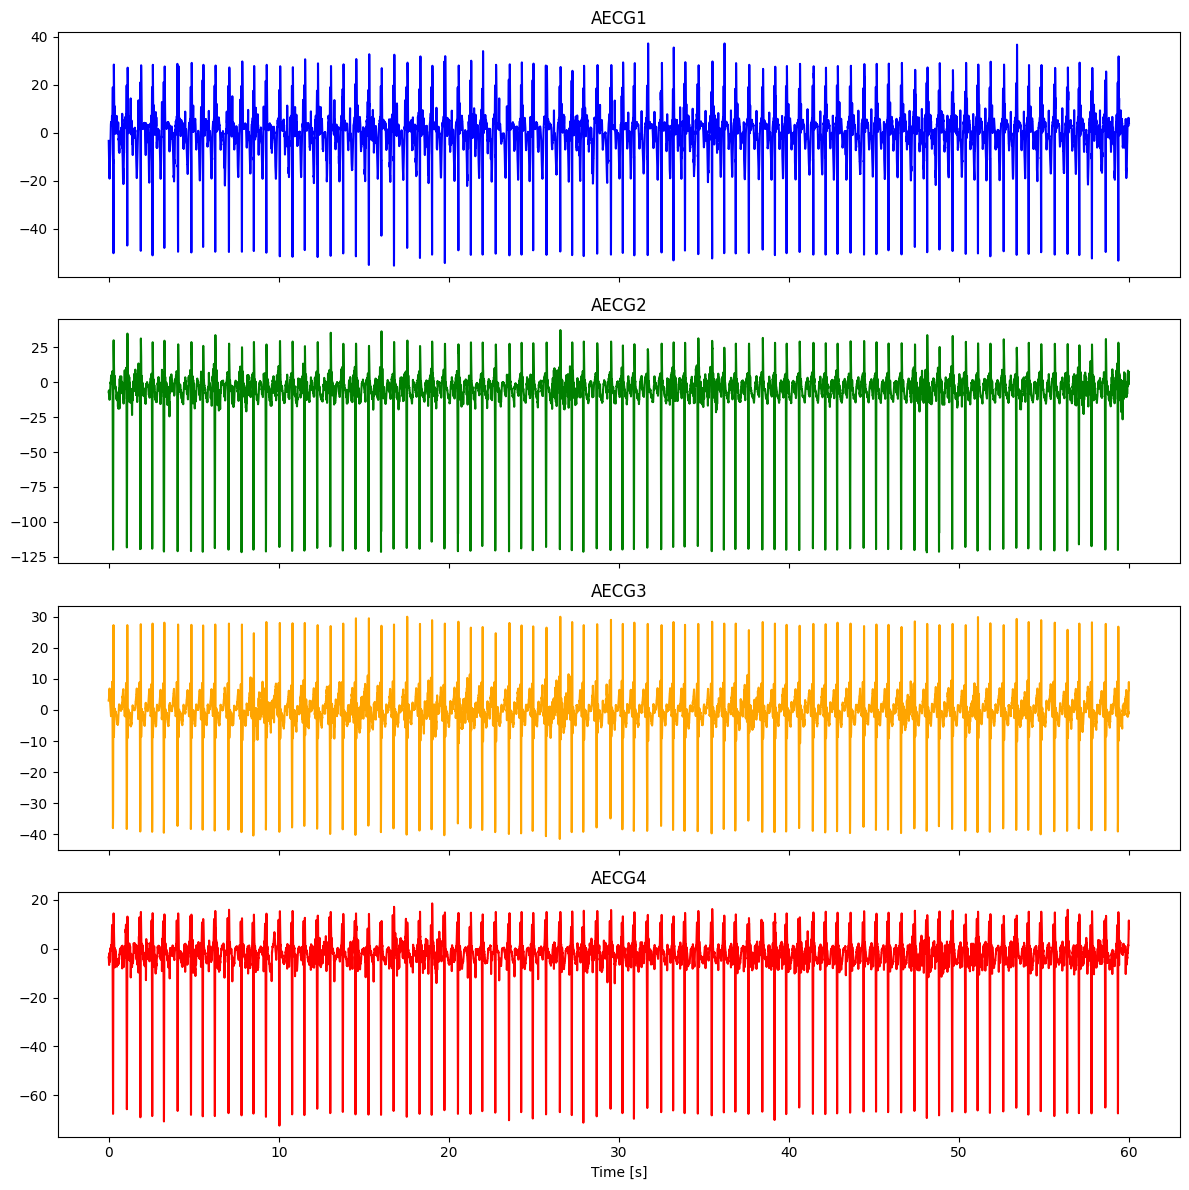

In [6]:
def extract_stochastic_process(filename, num_realizations):
    df = pd.read_csv(filename, skiprows=2, header=None)
    realizations, labels = [], []
    for i in range (1,num_realizations+1):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        realizations.append(AECG_cleaned.astype(float))
        labels.append("AECG"+str(i))

    return realizations, labels

num_realizations = 4
realizations, labels = extract_stochastic_process(sp_path, num_realizations)
sr = 1000 
colors = ['blue', 'green', 'orange', 'red']

S1 = StochasticProcess(num_realizations, realizations, labels, colors, sr)
S1.plot()

# <b>Baseline Wander Remover</b>

In [7]:
BW_freq = 3
BW_num_taps = 1000
PLI_freq = 50

ecg_cleaner = ECGcleaner(sr, BW_freq, PLI_freq)

S2 = StochasticProcess(num_realizations, [ecg_cleaner.remove_baseline_wander(r, BW_num_taps+1) for r in S1], labels, colors, sr)

##### **CONSIDERATIONS**
1. A linear-phase filter is necessary to ensure the preservation of the waveform, and thus the characteristics of the ECG.

2. A FIR filter with symmetric coefficients is the only way to guarantee linear-phase filtering.

3. `num_taps = 1000`, proposed by the authors of the paper, generates a fractional delay in the signal due to the even number of coefficients, which prevents having a "center" in the filter response. This causes an error in the `filtfilt` call. Therefore, a filter of length 1001 was used to ensure an integer delay of $\frac{1001 -1}{2} = 500$ samples, equivalent to 0.5 seconds at a sampling rate of 1000 Hz.

4. Since the ground truth peaks refer to the unshifted signal, `filtfilt` was used to perform bidirectional filtering, thus canceling the delay. This:
    - increases attenuation in the transition band and the stopband, since the filter's frequency response is $|H(f)|²$
    - may cause artifacts at the signal edges. However, in addition to the fact that no evident artifacts were found through visual analysis, since operations often involve averaging ECG complexes (which rarely involve the signal edges), minor artifacts are completely acceptable.

# <b>Power-line interference canceller</b>

In [8]:
notch_quality_factor = 30

S3 = StochasticProcess(num_realizations, [ecg_cleaner.remove_PLI_notch(r, notch_quality_factor) for r in S2], labels, colors, sr)

##### **CONSIDERATIONS**

1. The paper proposes an adaptive approach to dynamically estimate the amplitude, frequency, and phase of the signal component related to PLI. The underlying idea is to use the MSE to find the parameters of the estimated interference that minimize the difference between the "noisy" original signal and the estimated interference itself. The goal is to obtain an estimate of the interference $\tilde{x}$ as close as possible to the actual interference $x$, so that the error reflects only the interference-free part of the signal. 
This approach is based on the assumption that the PLI is predictable and can be modeled as a sinusoidal function at a certain frequency. Unfortunately, this is only the basic idea, and the actual proposal in the paper was much more complex. I tried to implement a simplified version of this approach, but it produced poor results.

2. To handle powerline interference, I relied on an IIR notch filter at 50 Hz. Being an IIR filter, it has the advantage of higher efficiency, as it requires fewer coefficients in memory. The disadvantage of the IIR filter is that it cannot be linear phase, so it may introduce phase distortions in the signal. However, following a visual analysis of the signals, no distortions significant enough to affect the typical ECG waveform were detected.


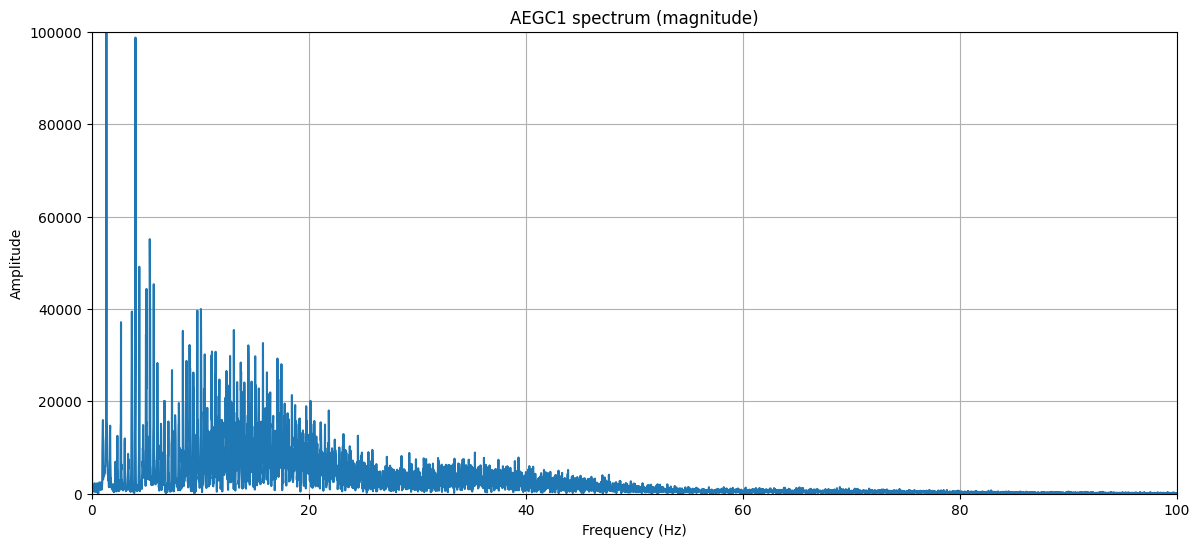

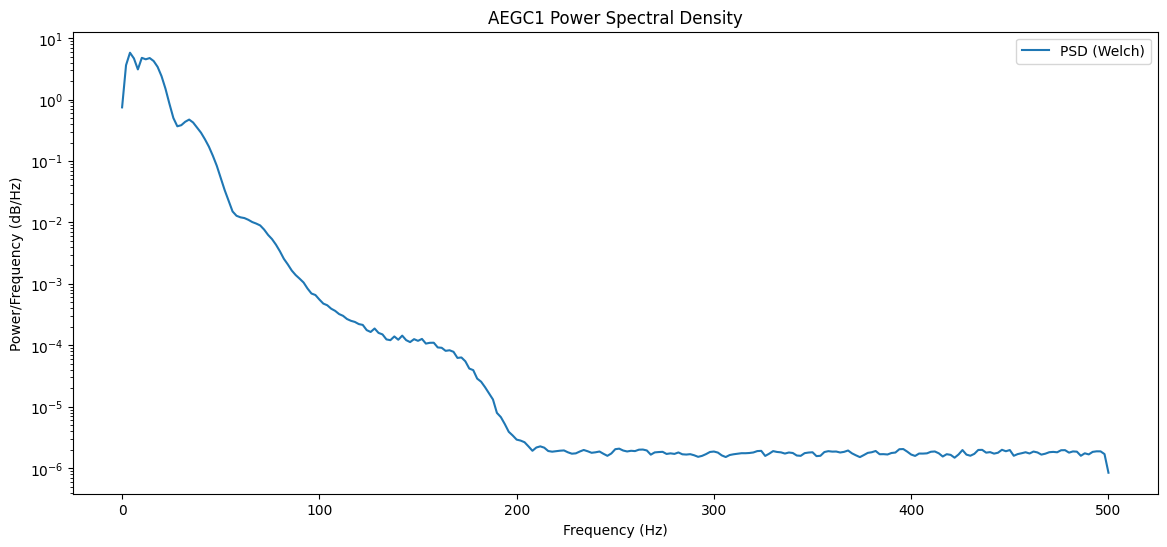

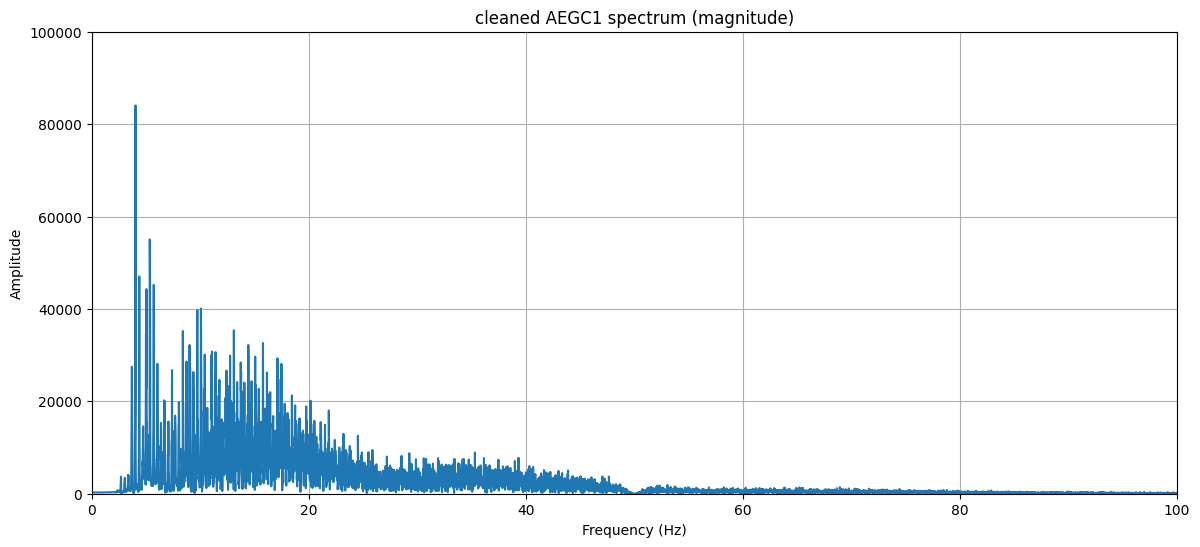

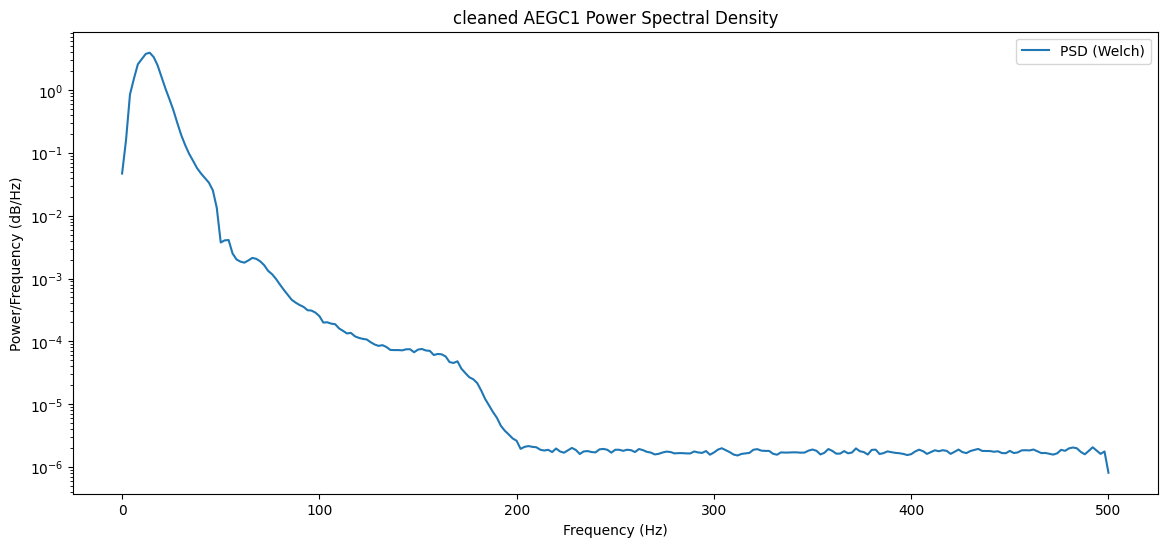

In [9]:
S1.plot_realization_spectrum(0, "AEGC1 spectrum (magnitude)")
S1.plot_realization_PSD(0, 500, "AEGC1 Power Spectral Density")

S3.plot_realization_spectrum(0, "cleaned AEGC1 spectrum (magnitude)")
S3.plot_realization_PSD(2, 500, "cleaned AEGC1 Power Spectral Density")

# **Upsampling**

##### **CONSIDERATIONS**

The authors of the paper performed upsampling to improve the matching between the template and the actual MECG complexes, as having more samples per unit of time allows for more precise alignment of the two signals, minimizing phase and temporal errors. Since the authors increased the sampling rate to 2000 Hz, I decided to do the same.

To achieve this, I relied on the `resample` method from `scipy.signal`. In brief:
1. It computes the spectrum of the signal.
2. It extends it to the desired frequency using zero-padding.
3. It computes the IFFT to obtain the time-domain signal with interpolated samples.


In [10]:
upsample_factor = 2
new_sr = sr * upsample_factor

S4 = S3.resample_process(new_sr)

upsampled_time = S4.timestamps

# **Maternal QRS Detector**



### **1) QRS enhancement method**

The idea is to leverage the strong correlation between the QRS components of the various signals and the low correlation between the noise characterizing them, assuming that each realization of the process is characterized by these two components.  
Steps:

1. Normalization of the channels by dividing each channel by its Euclidean norm.
2. Application of PCA to the channels.
3. Extraction of the first component as the ECG with enhanced QRS complexes.

This procedure generates a signal $\tilde{x}$ associated with the component with the highest variance, which is assumed to be, at this point of the pipeline, the Maternal QRS signal.


In [11]:
maternal_template_duration = 0.10
maternal_threshold_factor = 0.5

MQRS_detector = QRSdetector(S4, maternal_template_duration, maternal_threshold_factor, new_sr)
maternal_enhanced_QRS, maternal_explained_variance = MQRS_detector.get_enhanced_QRS()

Explained variance of PC1 (Maternal QRS): 68%


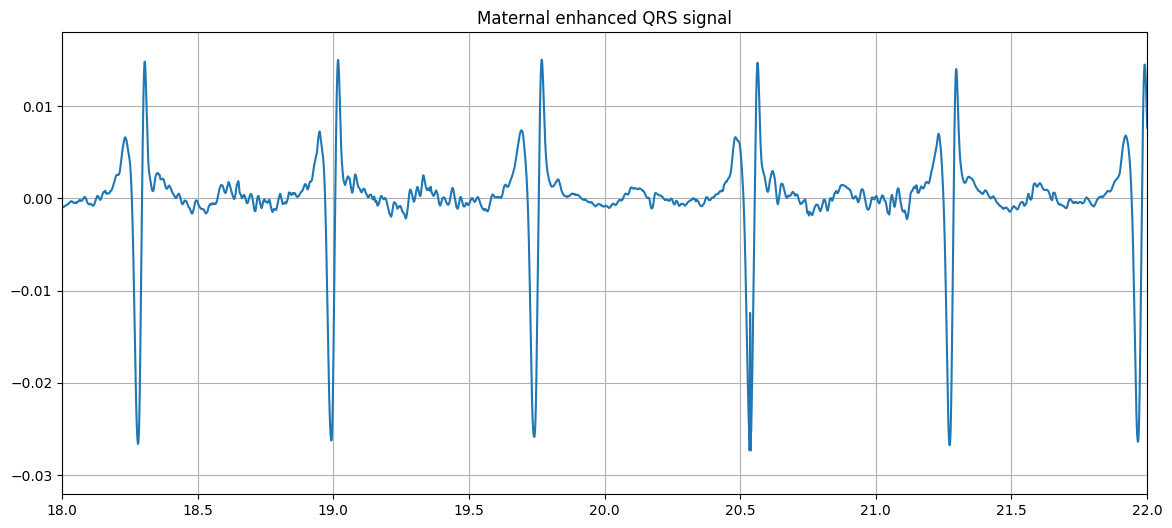

In [12]:
print(f"Explained variance of PC1 (Maternal QRS): {round(maternal_explained_variance)}%")
plt.figure(figsize=(14, 6))
plt.plot(upsampled_time, maternal_enhanced_QRS)
plt.title('Maternal enhanced QRS signal')
plt.xlim(18, 22)
plt.grid(True)
plt.show()

### **2) QRS detection method**

The idea here is to use a QRS template $h(t)$ and calculate the cross-correlation $R_{\tilde{x},h}(τ)$ with the signal $\tilde{x}$.

The local maxima (peaks) of $R_{\tilde{x},h}(τ)$, above a certain threshold, will be saved in a vector `[r1, r2, ... , rN]`, which will identify the N positions of the mother's QRS peaks.


In [13]:
maternal_qrs_template = MQRS_detector.create_qrs_template(maternal_enhanced_QRS)

Maternal QRS template length in samples: 200


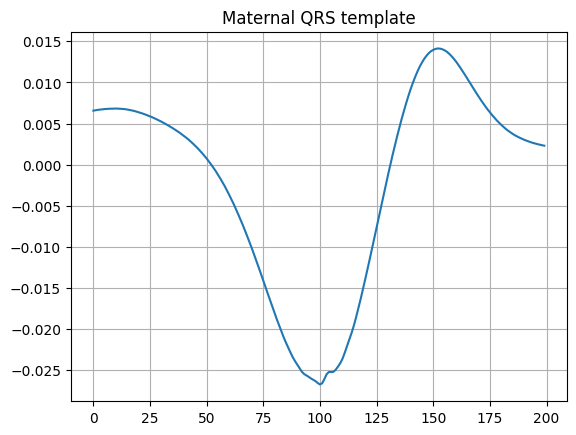

In [14]:
print(f"Maternal QRS template length in samples: {len(maternal_qrs_template)}")
plt.plot(maternal_qrs_template)
plt.title('Maternal QRS template')
plt.grid(True)
plt.show()

In [15]:
maternal_peaks, maternal_cross_corr = MQRS_detector.detect_qrs(maternal_enhanced_QRS, maternal_qrs_template)

QRS peaks detected: 80, with correlation threshold factor: 50 %


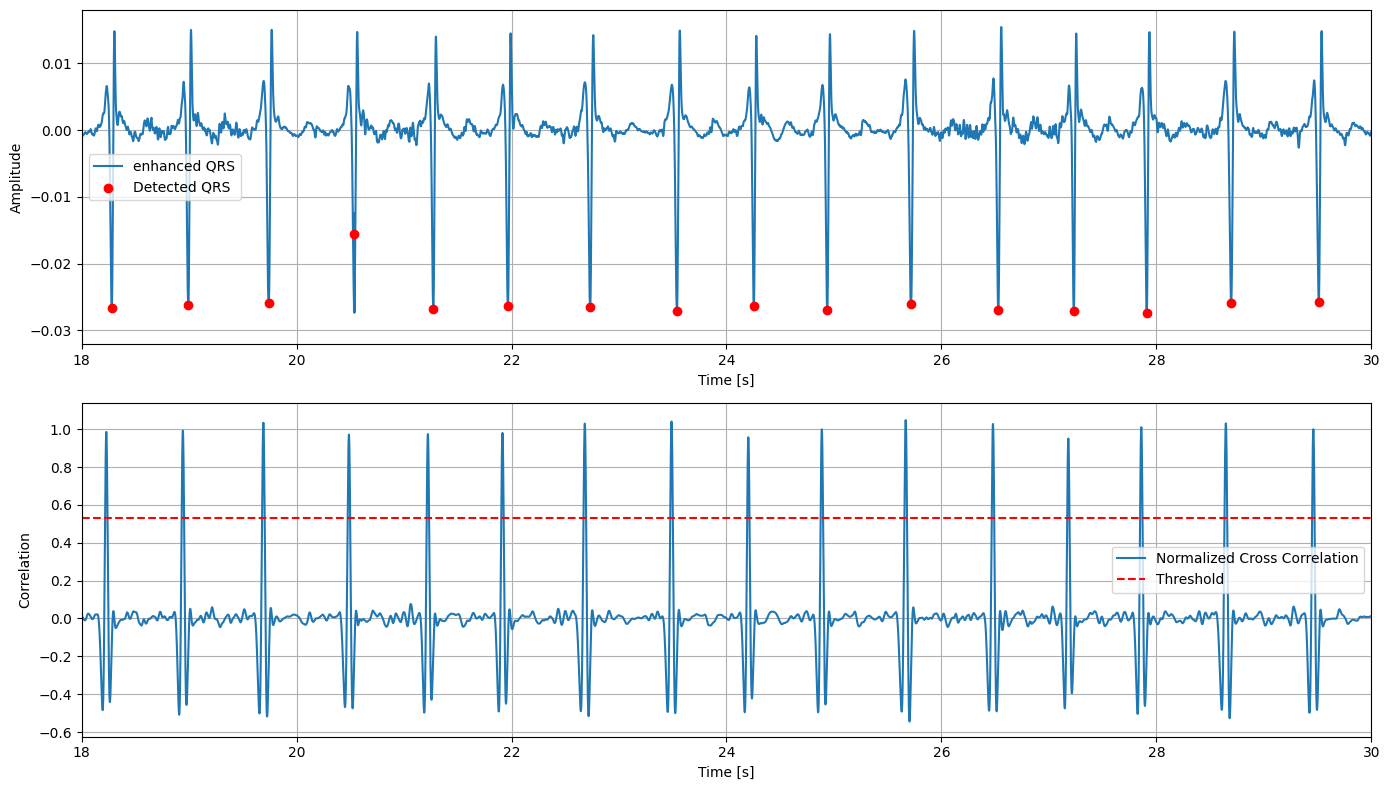

In [16]:
def plot_correlation_data(cross_corr, peaks, gt_peaks, threshold_factor, time, enhanced_QRS, gt=False):
    corr_max = np.max(cross_corr)
    print(f"QRS peaks detected: {len(peaks)}, with correlation threshold factor: {round(threshold_factor*100)} %")
    if gt: print(f"QRS peaks (ground truth): {len(gt_peaks)}")
    
    plt.figure(figsize=(14, 8))

    # Enhanced QRS (with detected peaks)
    plt.subplot(2, 1, 1)
    plt.plot(time, enhanced_QRS, label="enhanced QRS")
    plt.scatter(time[peaks], enhanced_QRS[peaks], color='red', label="Detected QRS", zorder=2)
    if gt: plt.scatter(upsampled_time[gt_peaks], enhanced_QRS[gt_peaks], color='orange', label="Ground Truth QRS peaks", zorder=2)

    plt.legend()
    plt.xlabel("Time [s]")
    plt.xlim(18, 30)
    plt.ylabel("Amplitude")
    plt.grid()

    # Cross-correlation
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(cross_corr)], cross_corr, label="Normalized Cross Correlation")
    plt.axhline(y=threshold_factor*corr_max, color='red', linestyle='--', label="Threshold")
    plt.legend()
    plt.xlim(18, 30)
    plt.xlabel("Time [s]")
    plt.ylabel("Correlation")
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_correlation_data(maternal_cross_corr, maternal_peaks, [], maternal_threshold_factor, upsampled_time, maternal_enhanced_QRS)

# **Maternal ECG Canceller**

A MECG portion is defined as follows:
- *P wave:* 0.20 s
- *QRS complex:* 0.10 s
- *T wave:* 0.40 s


### **1) MECG identification**

The MECG is identified using a windowing-based method: a window is constructed, centered on the peak of the QRS complex, following the characteristics described above.  
The window has a duration of 0.70 seconds, consisting of:  
- 0.25 seconds before the QRS peak  
- 0.45 seconds after the QRS peak


In [17]:
maternal_P_wave_duration = 0.20
maternal_T_wave_duration = 0.40

MECG_estimator = ECGestimator(S4, maternal_P_wave_duration, maternal_template_duration, maternal_T_wave_duration, new_sr, labels)

In [18]:
real_MECGs, real_MECGs_positions = MECG_estimator.get_real_ECGs(maternal_peaks)

### **2) Average MECG**

Let $x$ be the original signal, which is the sum of the maternal ECG, fetal ECG, and noise.  
An average MECG complex $μ$ is obtained by averaging the N MECG complexes extracted from $x$ through windowing.

In [19]:
MECG_averages = MECG_estimator.get_ECG_averages(real_MECGs)

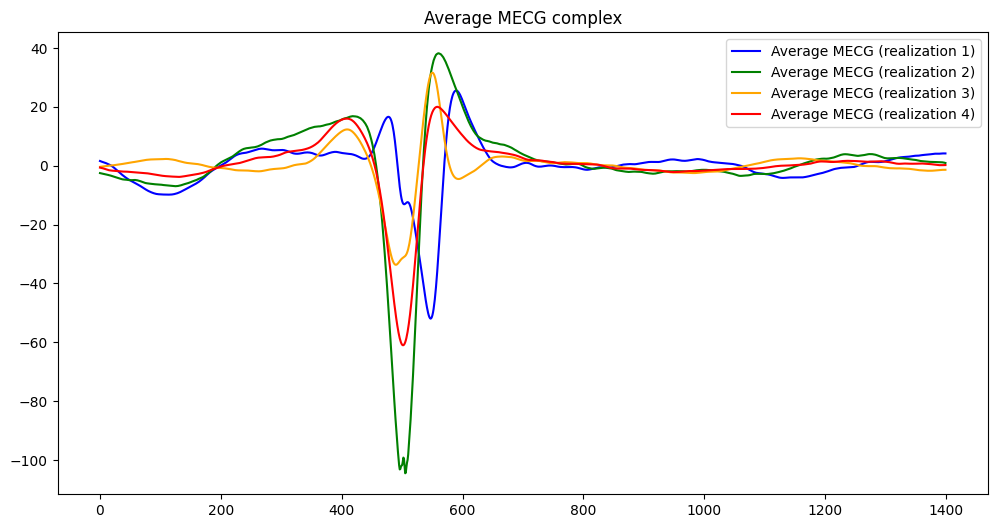

In [20]:
plt.figure(figsize=(12, 6))
for i in range(num_realizations): plt.plot(MECG_averages[labels[i]], color=colors[i], label=f"Average MECG (realization {i+1})")
plt.legend()
plt.title("Average MECG complex")
plt.show()

### **3) MECG Scaling & Subtraction using MSE Minimization**

The extracted MECG $μ$ is divided into its three components:
- $\mu_{QRS} →$ contains the QRS complex
- $\mu_P →$ contains the P wave
- $\mu_T →$ contains the T wave

The idea is as follows: for each MECG complex in $x$, $\mu_{QRS}$, $\mu_P$, and $\mu_T$ are scaled by three distinct factors, $a_{QRS}$, $a_P$, and $a_T$, respectively, so that the average MECG complex $\mu$ exactly matches the real MECG complex $m$.

By doing so, a more accurate estimate of the single MECG complex is obtained. This estimate, called $\hat{m}$, is defined as:

\begin{align*}
    \hat{m} = Ma
\end{align*}

where $a$ is the array containing the three scaling factors:

\begin{bmatrix}
    a_P\\
    a_{QRS}\\
    a_T
\end{bmatrix}

and $M$ is a 3x3 diagonal matrix containing the three components of $\mu$:

\begin{bmatrix}
    \mu_P & 0 & 0\\
    0 & \mu_{QRS} & 0\\
    0 & 0 & \mu_T
\end{bmatrix}

Since the sampling rate at this point is 2000 Hz:
- The length of $\mu_P$ is $0.20 \, \text{s} \times 2000 \, \text{Hz} = 400$ samples
- The length of $\mu_{QRS}$ is $0.10 \, \text{s} \times 2000 \, \text{Hz} = 200$ samples
- The length of $\mu_T$ is $0.40 \, \text{s} \times 2000 \, \text{Hz} = 800$ samples

Thus, $M$ in explicit form can be represented as:

\begin{bmatrix}
    \mu_P[0] & 0 & 0\\
    \mu_P[1] & 0 & 0\\
    ... & 0 & 0\\
    \mu_P[399] & 0 & 0\\
    0 & \mu_{QRS}[0] & 0\\
    0 & \mu_{QRS}[1] & 0\\
    0 & ... & 0\\
    0 & \mu_{QRS}[199] & 0\\
    0 & 0 & \mu_T[0]\\
    0 & 0 & \mu_T[1]\\
    0 & 0 & ...\\
    0 & 0 & \mu_T[799]\\
\end{bmatrix}

To find $a$, the $MSE$ between the estimated MECG complex $\hat{m} = Ma$ and the real MECG complex $m$ is minimized:

\begin{align*}
    \hat{a} = argmin_{a}||Ma - m||² = argmin_{a}(ϵ²)
\end{align*}

By deriving and setting the derivative to zero, the solution is:

\begin{align*}
    \hat{a} = (M^T M)^{-1} M^T m
\end{align*}

$\hat{a}$ will contain the scaling values (scalars) associated with the three components of the complex, which will then be multiplied by $\mu$ (component-wise) to obtain the estimated maternal ECG complex $m$.


In [21]:
mu_portions = MECG_estimator.get_mu_portions(MECG_averages)

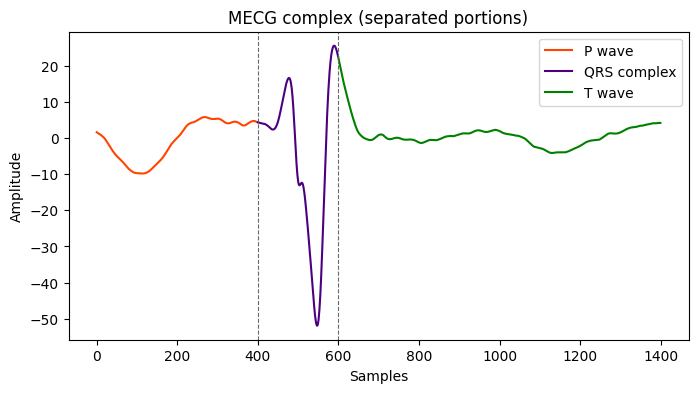

In [22]:
# plot of the three portions of mu for a single realization, just as an example
mu = mu_portions["AECG1"]

x1 = np.arange(len(mu[0]))
x2 = np.arange(len(mu[1])) + len(mu[0])
x3 = np.arange(len(mu[2])) + len(mu[0]) + len(mu[1])

plt.figure(figsize=(8, 4))

plt.plot(x1, mu[0], label="P wave", color='orangered')
plt.plot(x2, mu[1], label="QRS complex", color='indigo')
plt.plot(x3, mu[2], label="T wave", color='green')

plt.axvline(len(mu[0]), color='dimgrey', linewidth=0.8, linestyle='--')
plt.axvline(len(mu[0]) + len(mu[1]), color='dimgrey', linewidth=0.8, linestyle='--')

plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("MECG complex (separated portions)")
plt.legend()
plt.show()

In [23]:
M_matrixes = MECG_estimator.get_M_matrixes(mu_portions)

estimated_MECGs = MECG_estimator.get_estimated_ECGs(real_MECGs, M_matrixes, mu_portions)

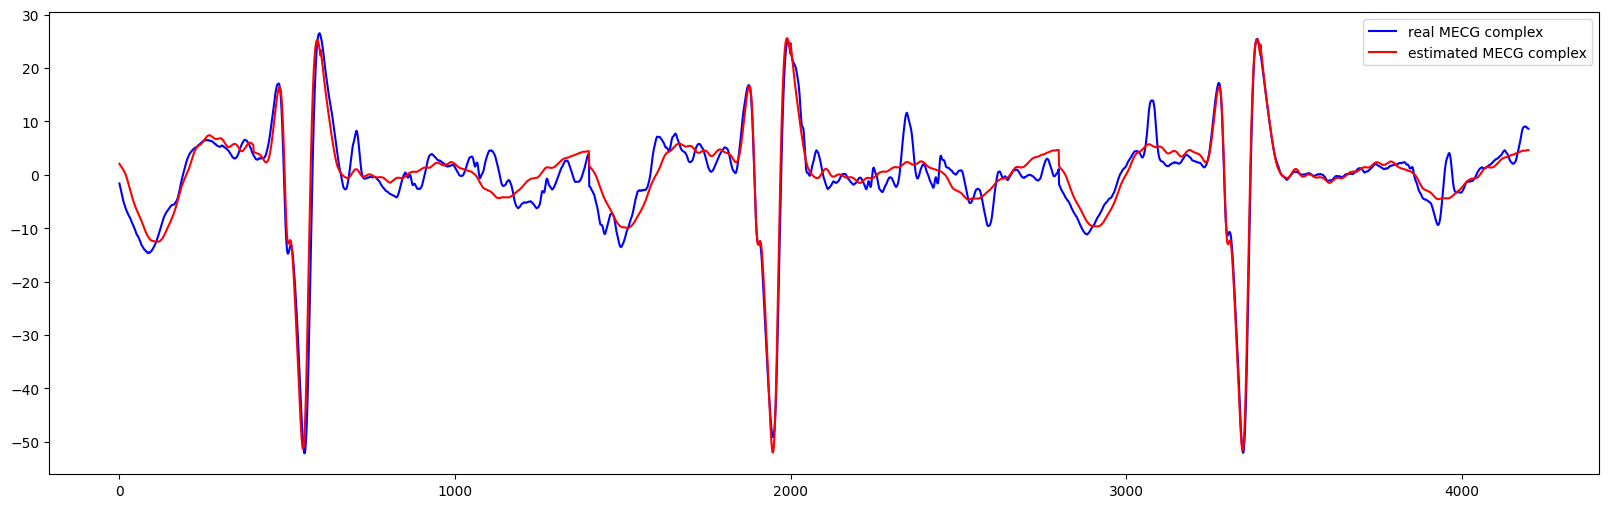

In [24]:
# comparison between first three real (blue) and estimated (red) MECGs for the first realization, just as an example
channel = "AECG1"
first_three_reals_MECGs = np.concatenate([real_MECGs[channel][0], real_MECGs[channel][1], real_MECGs[channel][2]])
first_three_estimated_MECGs = np.concatenate([estimated_MECGs[channel][0], estimated_MECGs[channel][1], estimated_MECGs[channel][2]])

plt.figure(figsize=(20, 6))
plt.plot(first_three_reals_MECGs, color='blue', label="real MECG complex")
plt.plot(first_three_estimated_MECGs, color='red', label="estimated MECG complex")
plt.legend()
plt.show()

In [25]:
residual_realizations = []

for i in range(num_realizations): 
    residual_realizations.append(MECG_estimator.cancel_ECG(S4.get_realization_by_index(i), real_MECGs_positions[labels[i]], real_MECGs[labels[i]], estimated_MECGs[labels[i]]))

S5 = StochasticProcess(num_realizations, residual_realizations, labels, colors, new_sr)

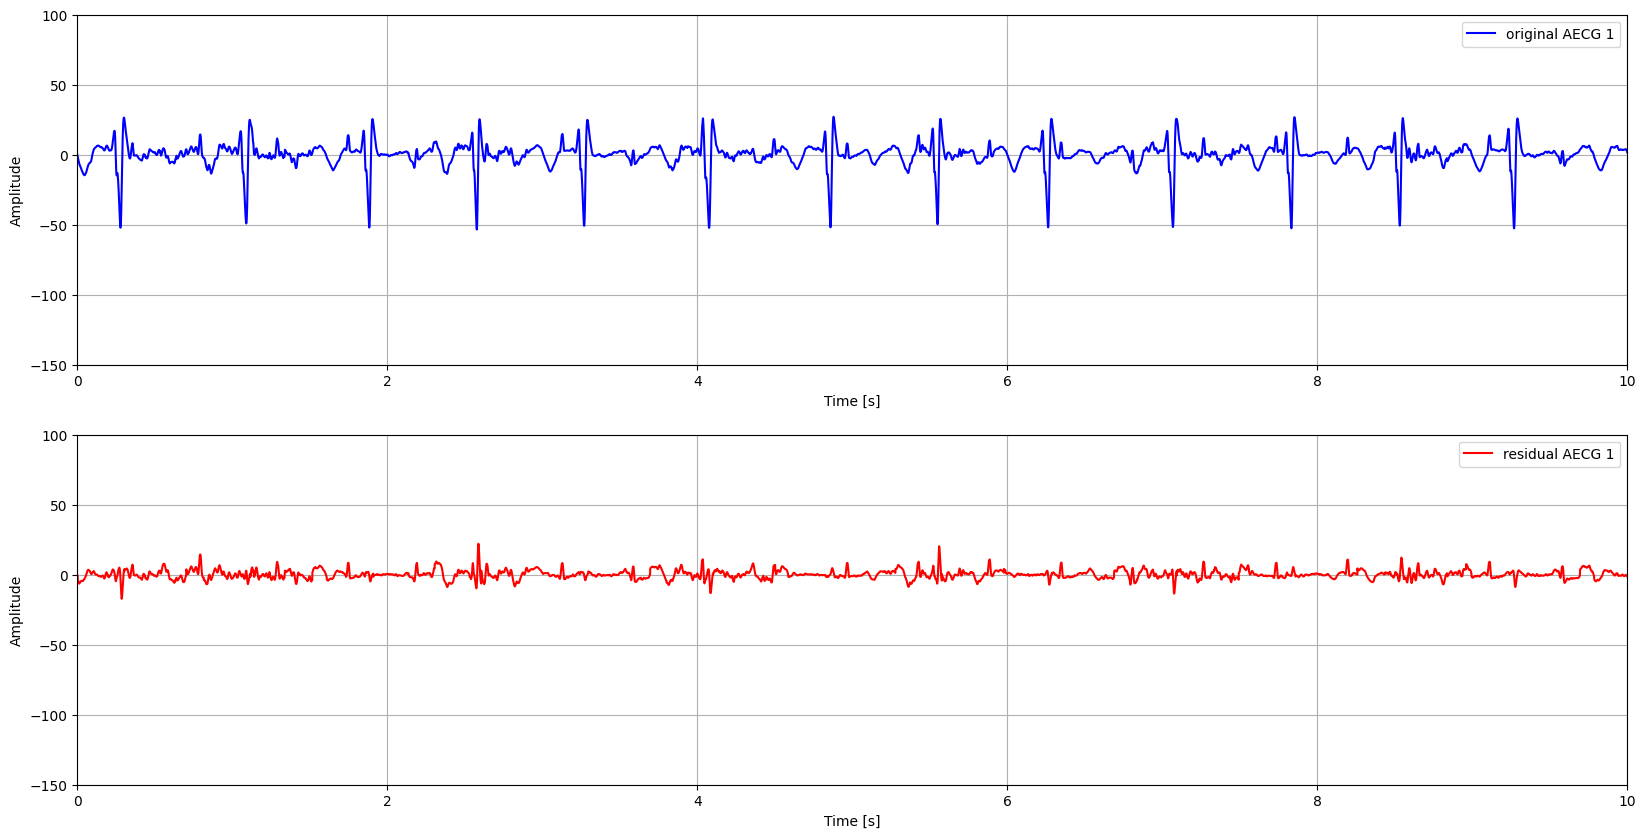

In [26]:
# Comparison between the first original realization (MECG + FECG + noise) and the first residual realization (FECG + noise), just as an example
plt.figure(figsize=(20, 10))

index = 0

plt.subplot(2, 1, 1)
plt.plot(upsampled_time, S4.get_realization_by_index(index), color='blue', label="original AECG 1")
plt.legend()
plt.xlabel("Time [s]")
plt.xlim(0, 10)
plt.ylim(-150, 100)
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(upsampled_time, S5.get_realization_by_index(index), color='red', label="residual AECG 1")
plt.legend()
plt.xlabel("Time [s]")
plt.xlim(0, 10)
plt.ylim(-150, 100)
plt.ylabel("Amplitude")
plt.grid()

plt.show()

# **Fetal QRS Detector**

The procedure is the same as that used for the maternal ECG:

stochastic process → enhanced_QRS → QRS_template → correlation between QRS_template and enhanced_QRS. 

The only difference is that, after removing the MECG signal, the component with the largest variance is assumed to be the Fetal QRS signal

In [27]:
# fetal peaks (ground truth)
with open(gt_path, 'r') as file: gt = np.array([int(line.strip()) for line in file])

# adapting to new sample rate
gt_fetal_peaks = gt * upsample_factor

In [28]:
fetal_duration_template = 0.1
fetal_threshold_factor = 0.30

FQRS_detector = QRSdetector(S5, fetal_duration_template, fetal_threshold_factor, new_sr)

fetal_enhanced_QRS, fetal_explained_variance = FQRS_detector.get_enhanced_QRS()
print(f"Explained variance of PC1 (Fetal QRS) : {round(fetal_explained_variance)}%")

Explained variance of PC1 (Fetal QRS) : 44%


In [29]:
fetal_QRS_template = FQRS_detector.create_qrs_template(fetal_enhanced_QRS)

Fetal QRS template length in samples: 200


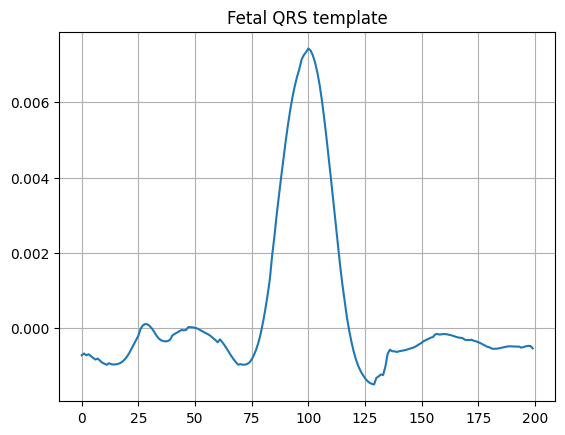

In [30]:
print(f"Fetal QRS template length in samples: {len(fetal_QRS_template)}")
plt.plot(fetal_QRS_template)
plt.title('Fetal QRS template')
plt.grid(True)
plt.show()

In [31]:
fetal_peaks, fetal_cross_corr = FQRS_detector.detect_qrs(fetal_enhanced_QRS, fetal_QRS_template)

QRS peaks detected: 118, with correlation threshold factor: 30 %
QRS peaks (ground truth): 145


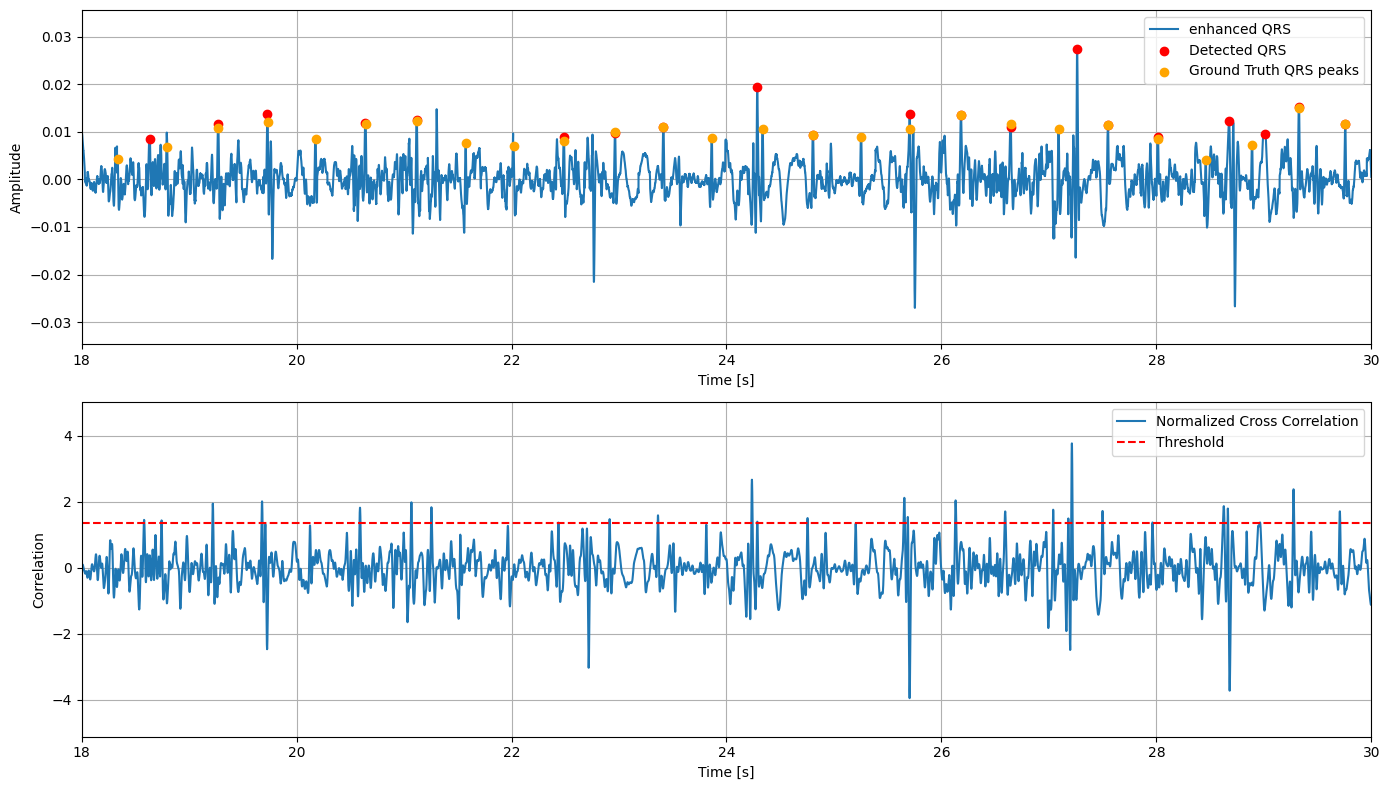

In [32]:
plot_correlation_data(fetal_cross_corr, fetal_peaks, gt_fetal_peaks, fetal_threshold_factor, upsampled_time, fetal_enhanced_QRS, gt=True)

# **Fetal ECG Detector**

The procedure is the same as described above: once the peaks are extracted, the windows associated with the fetal ECG complexes are extracted and averaged to obtain an estimate of the fetal ECG complex for each realization.


In [33]:
fetal_P_wave_duration = 0.20
fetal_T_wave_duration = 0.40

FECG_estimator = ECGestimator(S5, fetal_P_wave_duration, fetal_duration_template, fetal_T_wave_duration, new_sr, labels)

real_FECGs, _ = FECG_estimator.get_real_ECGs(fetal_peaks)
gt_FECGs, _ = FECG_estimator.get_real_ECGs(gt_fetal_peaks)

FECG_averages = FECG_estimator.get_ECG_averages(real_FECGs)
gt_FECG_averages = FECG_estimator.get_ECG_averages(gt_FECGs)

In [34]:
S6 = StochasticProcess(num_realizations, [FECG_averages[label] for label in FECG_averages], labels, colors, new_sr)
gt_S6 = StochasticProcess(num_realizations, [gt_FECG_averages[label] for label in gt_FECG_averages], labels, colors, new_sr)

# **Evaluation Metrics**

These metrics are used to assess how closely the average fetal ECG complex computed from the estimated QRS peaks matches the average fetal ECG complex computed from the ground truth QRS peaks for each realization.

This test effectively evaluates the fetal QRS peak detection method, not the quality of the extracted fetal signal. It assumes that the extracted fetal signal, **S5**, is a good estimate of the real fetal signal. Under this assumption, by calculating an average FECG complex using the FECG complexes centered on the ground truth peaks, the resulting average complex, **gt_S6**, can be considered a good approximation of the real average FECG complex.  
At this point, the evaluation focuses on how closely the average complex calculated from the estimated peaks, **S6**, matches **gt_S6**. In this way, the quality of fetal QRS peak detection from the signal **S5** is assessed.

The "closeness" between **S6** and **gt_S6** is measured using:

- **Correlation**: to provide a qualitative measure of the FECG shape.
- **Mean Squared Error (MSE)**: to evaluate the quantitative difference in amplitude between the two ECG complexes.


In [35]:
evaluator = Evaluator(S6, gt_S6)

correlations, mean_correlation = evaluator.get_correlations()
MSEs, mean_MSE = evaluator.get_MSEs()

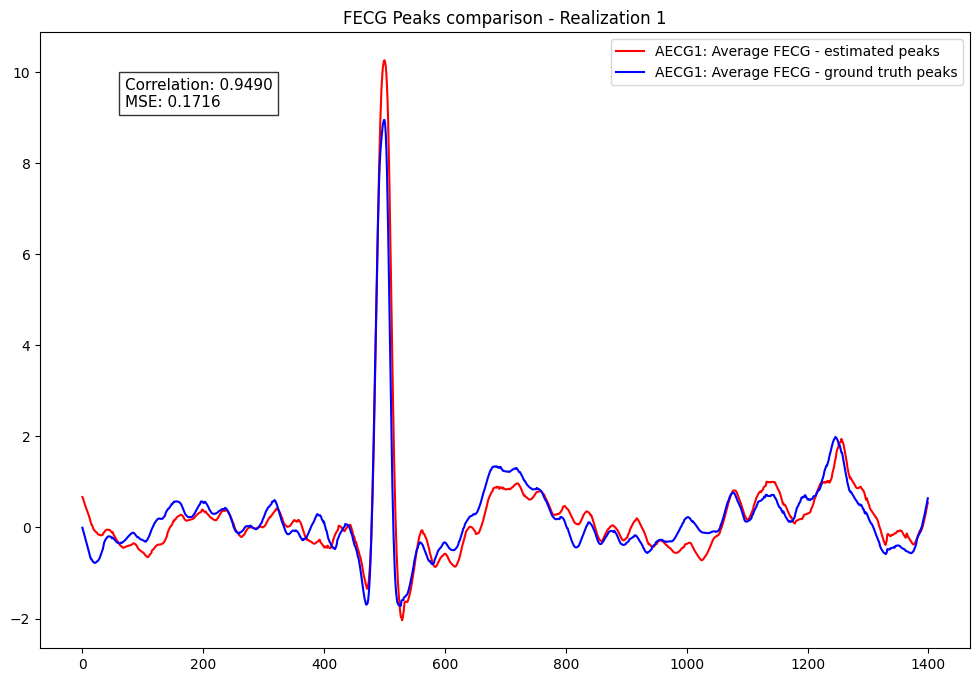

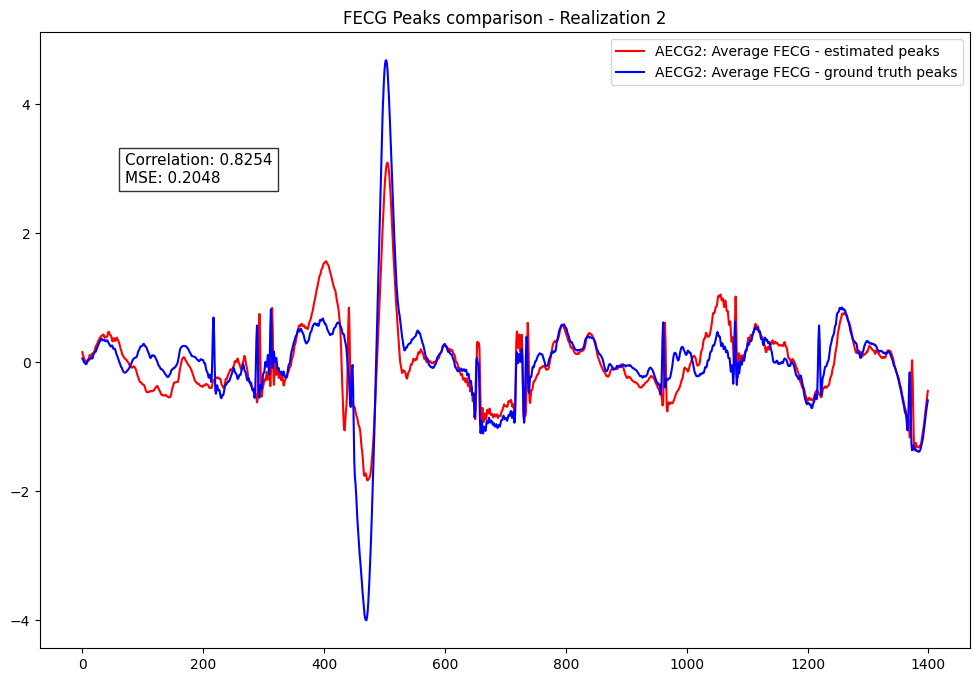

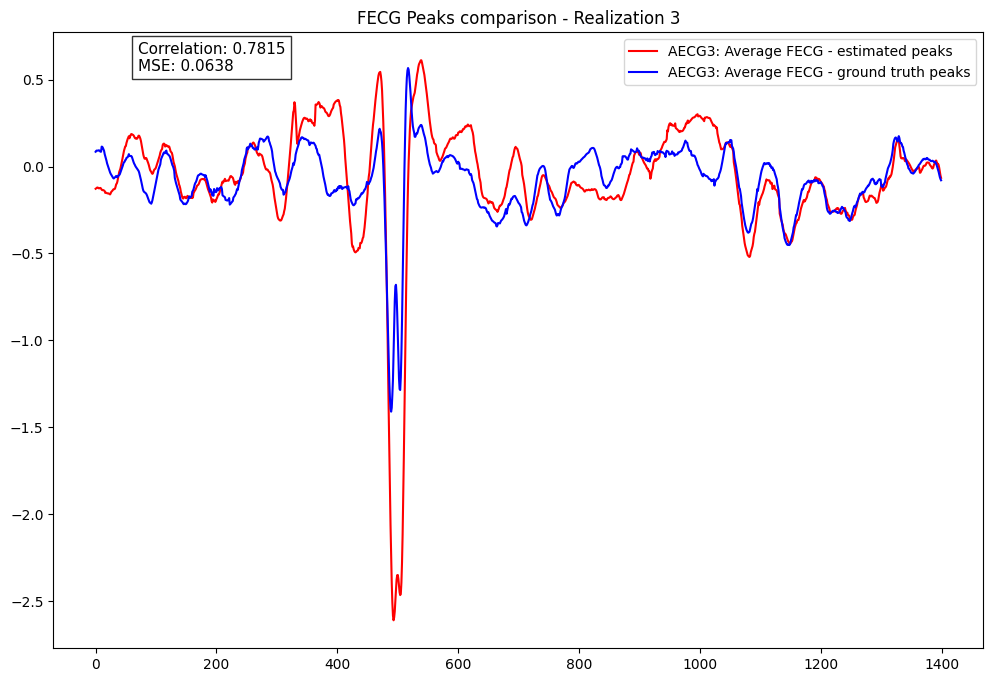

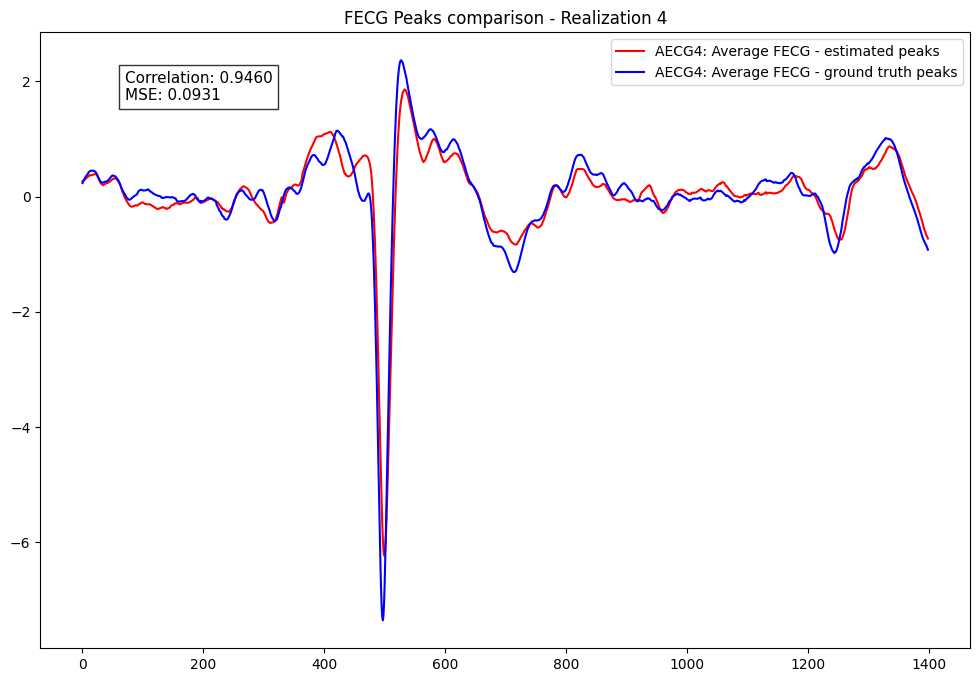

In [36]:
evaluator.plot_comparison(correlations, MSEs, os.path.join(results_path, sp), plot=True, save=False)

In [37]:
print(f"Average final correlation: {round(mean_correlation, 2)*100}%")
print(f"Average final MSE: {round(mean_MSE, 2)}")

Average final correlation: 88.0%
Average final MSE: 0.13
